In [1]:
import os
import sys
import warnings
import logging
def prompt_no_warning(message, category, filename, lineno, file=None, line=None):
    pass

warnings.showwarning = prompt_no_warning

warnings.filterwarnings("ignore")

warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

os.environ["PYTHONWARNINGS"] = "ignore"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

logging.getLogger("gym").setLevel(logging.ERROR)
logging.getLogger("gymnasium").setLevel(logging.ERROR)
logging.getLogger("shimmy").setLevel(logging.ERROR)
logging.getLogger("distutils").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("jupyter_client").setLevel(logging.ERROR)

In [2]:
%pip install -q -U "gymnasium[mujoco]" "gymnasium[other]" "gymnasium[box2d]"
%pip install -q PyOpenGL PyOpenGL_accelerate
%pip install "shimmy[dm-control]" dm_control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 145.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 74.8 MB/s eta 0:00:00


In [3]:
os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'
os.environ["SDL_AUDIODRIVER"] = "dummy"
os.environ["XDG_RUNTIME_DIR"] = "/tmp"

import os.path
import json
import warnings ; warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from collections import deque

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import count

import time
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from gymnasium.wrappers import FlattenObservation
import shimmy


import shutil
import copy
import gc

import glob
from IPython.display import Video, display

%matplotlib inline

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [4]:
plt.style.use('ggplot')
params = {
    'figure.figsize': (12, 7),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
}

pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

# Wrappers

In [5]:
class ActionRepeatWrapper(gym.Wrapper):
    def __init__(self, env, repeat):
        super().__init__(env)
        self.repeat = repeat

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}

        for _ in range(self.repeat):
            obs, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            if terminated or truncated:
                break

        return obs, total_reward, terminated, truncated, info

In [6]:
class ObsStackWrapper(gym.Wrapper):
    def __init__(self, env, k):
        super().__init__(env)
        self.k = k
        self.frames = deque(maxlen=k)


        low = np.array(env.observation_space.low, dtype=np.float32).flatten()
        high = np.array(env.observation_space.high, dtype=np.float32).flatten()


        low = np.repeat(low, k, axis=0)
        high = np.repeat(high, k, axis=0)

        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        obs = np.array(obs, dtype=np.float32).flatten()
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get_obs(), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        obs = np.array(obs, dtype=np.float32).flatten()
        self.frames.append(obs)
        return self._get_obs(), reward, terminated, truncated, info

    def _get_obs(self):
        return np.concatenate(self.frames, axis=0)


In [7]:
class PixelObservationWrapper(gym.Wrapper):
    def __init__(self, env, img_size, obs_stack):
        super().__init__(env)
        self.img_size = img_size
        self.obs_stack = obs_stack
        self.frames = deque(maxlen=obs_stack)

        # Define the new observation space
        self.observation_space = gym.spaces.Box(
            low=0, high=255,
            shape=(obs_stack * 3, img_size[0], img_size[1]),
            dtype=np.uint8
        )

    def _get_obs(self):
        # Render the environment to get the current frame
        frame = self.env.render()  # (H_orig, W_orig, 3)
        if frame is None:
            frame = np.zeros((self.img_size[0], self.img_size[1], 3), dtype=np.uint8)

        # Convert to a tensor
        frame_t = torch.from_numpy(frame.copy()).permute(2, 0, 1).float()

        # Resize
        frame_t = F.interpolate(frame_t.unsqueeze(0), size=self.img_size, mode='bilinear', align_corners=False)
        frame_t = frame_t.squeeze(0).byte()  # Convert back to uint8

        return frame_t.numpy()  # Return shape: (3, img_size[0], img_size[1])

    def reset(self, **kwargs):
        # Reset the environment
        _, info = self.env.reset(**kwargs)
        frame = self._get_obs()
        # Fill the frame stack with the first frame
        for _ in range(self.obs_stack):
            self.frames.append(frame)
        return self._stack_frames(), info

    def step(self, action):
        # Take a step in the environment
        _, reward, terminated, truncated, info = self.env.step(action)
        frame = self._get_obs()
        self.frames.append(frame)
        return self._stack_frames(), reward, terminated, truncated, info

    def _stack_frames(self):
        # Concatenate frames along the channel dimension
        return np.concatenate(list(self.frames), axis=0)




def make_env_fn(env_name, action_repeat, img_size, obs_stack, pixel=True):
    # Environment creation

    env = gym.make(env_name, render_mode="rgb_array")
        #env = gym.make(env_name, render_mode="rgb_array",render_kwargs={"camera_id": 0})

    if isinstance(env.observation_space, gym.spaces.Dict):
        env = FlattenObservation(env)

    if action_repeat > 1:
        env = ActionRepeatWrapper(env, action_repeat)

    if pixel:

        env = PixelObservationWrapper(env, img_size=img_size, obs_stack=obs_stack)
    else:
        if obs_stack > 1:
            env = ObsStackWrapper(env, obs_stack)

    return env

# Replay Buffer

In [8]:
class ReplayBuffer():
    def __init__(self,
                 max_size=10000,
                 batch_size=64,
                 device="cuda"):
        self.states_buffer = np.empty(shape=(max_size), dtype=np.ndarray)
        self.actions_buffer = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rewards_buffer = np.empty(shape=(max_size), dtype=np.ndarray)
        self.next_states_buffer = np.empty(shape=(max_size), dtype=np.ndarray)
        self.dones_buffer = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0

        self.device = device

    def store(self, sample):
        s, a, r, p, d = sample
        self.states_buffer[self._idx] = s
        self.actions_buffer[self._idx] = a
        self.rewards_buffer[self._idx] = r
        self.next_states_buffer[self._idx] = p
        self.dones_buffer[self._idx] = d

        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size

        idxs = np.random.randint(0, self.size, size=batch_size)

        experiences = (
            torch.from_numpy(np.vstack(self.states_buffer[idxs])).float().to(self.device),
            torch.from_numpy(np.vstack(self.actions_buffer[idxs])).float().to(self.device),
            torch.from_numpy(np.vstack(self.rewards_buffer[idxs])).float().to(self.device),
            torch.from_numpy(np.vstack(self.next_states_buffer[idxs])).float().to(self.device),
            torch.from_numpy(np.vstack(self.dones_buffer[idxs])).float().to(self.device),
        )

        return experiences


    def __len__(self):
        return self.size


In [9]:
class ReplayBufferPixel:
    def __init__(self,
                 obs_shape,
                 action_shape,
                 max_size=10_000,
                 batch_size=64,
                 device='cuda'):
        self.states_buffer = np.zeros((max_size, *obs_shape), dtype=np.uint8)
        self.actions_buffer = np.zeros((max_size, action_shape), dtype=np.float32)
        self.rewards_buffer = np.zeros((max_size, 1), dtype=np.float32)
        self.next_states_buffer = np.zeros((max_size, *obs_shape), dtype=np.uint8)
        self.dones_buffer = np.zeros((max_size, 1), dtype=np.float32)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
        self.device = device

    def store(self, sample):
        s, a, r, p, d = sample
        self.states_buffer[self._idx] = s
        self.actions_buffer[self._idx] = a
        self.rewards_buffer[self._idx] = r
        self.next_states_buffer[self._idx] = p
        self.dones_buffer[self._idx] = d

        self._idx = (self._idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size

        idxs = np.random.choice(self.size, batch_size, replace=False)

        # Recover batch
        s = self.states_buffer[idxs]
        a = self.actions_buffer[idxs]
        r = self.rewards_buffer[idxs]
        p = self.next_states_buffer[idxs]
        d = self.dones_buffer[idxs]

        # Conversion in torch.Tensor
        s = torch.tensor(s, dtype=torch.float32, device=self.device)
        p = torch.tensor(p, dtype=torch.float32, device=self.device)

        a = torch.tensor(a, dtype=torch.float32, device=self.device)
        r = torch.tensor(r, dtype=torch.float32, device=self.device)
        d = torch.tensor(d, dtype=torch.float32, device=self.device)

        return s, a, r, p, d

    def __len__(self):
        return self.size


# CCFDM

## Encoders

In [10]:
class VectorQueryEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim=50, hidden_dim=64):
        super(VectorQueryEncoder, self).__init__()

        self.input_dim = input_dim
        self.embed_dim = embed_dim

        # 3-layer MLP (Input -> Hidden -> Hidden -> Feature)
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )

        # LayerNorm for stability in contrastive learning
        self.ln = nn.LayerNorm(embed_dim)

    def forward(self, obs):
        """
        Input: obs (Batch, input_dim)
        Output: q (Batch, embed_dim)
        """
        # Ensure the input is float
        if not isinstance(obs, torch.Tensor):
            obs = torch.tensor(obs, dtype=torch.float32)

        x = self.net(obs)

        x = self.ln(x)
        q = torch.tanh(x)

        return q

In [11]:
class VisualQueryEncoder(nn.Module):
    def __init__(self, input_shape, embed_dim=50, black_and_white=True):
        super(VisualQueryEncoder, self).__init__()

        self.bw = black_and_white
        in_channels, H, W = input_shape

        self.register_buffer(
            "rgb_weights",
            torch.tensor([0.299, 0.587, 0.114]).view(1, 1, 3, 1, 1))

        if self.bw:
            assert input_shape[0] % 3 == 0
            self.input_channels = input_shape[0] // 3
        else:
            self.input_channels = input_shape[0]

        # Define convolutional part (feature extractor)
        self.conv_net = nn.Sequential(
            nn.Conv2d(self.input_channels, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        # Automatically compute the output size of conv layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.input_channels, input_shape[1], input_shape[2])
            dummy_output = self.conv_net(dummy_input)
            self.n_flatten = dummy_output.view(1, -1).size(1)

        # Define the final linear head
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.n_flatten, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.Tanh()
        )

    def rgb_to_gray(self, x):
        """
        x: (B, 3*F, H, W)
        return: (B, F, H, W)
        """
        B, C, H, W = x.shape
        F = C // 3

        x = x.view(B, F, 3, H, W)                # (B, F, 3, H, W)
        gray = (x * self.rgb_weights).sum(dim=2)  # sum on RGB → (B, F, H, W)
        return gray


    def forward(self, obs):
        obs = obs / 255.

        if self.bw:
            obs = self.rgb_to_gray(obs)

        x = self.conv_net(obs)
        return self.fc(x)


class KeyEncoder(nn.Module):
    def __init__(self, query_encoder):
        super(KeyEncoder, self).__init__()

        # Create a copy of the QueryEncoder
        self.encoder = copy.deepcopy(query_encoder)

        # KeyEncoder must not receive gradients
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Set eval mode
        self.encoder.eval()

    def forward(self, obs):
        """
        Encodes observations (typically the next observations o_k').
        """
        with torch.no_grad():
            k = self.encoder(obs)
        return k

    def soft_update(self, query_encoder, tau=0.01):
        """
        Performs the Momentum Update (EMA) of the weights.
        """
        for param_k, param_q in zip(self.encoder.parameters(), query_encoder.parameters()):
            param_k.data.copy_(tau * param_q.data + (1.0 - tau) * param_k.data)


class ActionEmbedding(nn.Module):
    def __init__(self, action_dim, embedding_dim=50, hidden_dim=50):
        super(ActionEmbedding, self).__init__()

        # Input -> Hidden (ReLU) -> Hidden (ReLU) -> Output
        self.net = nn.Sequential(
            nn.Linear(action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )
        self.final_act = nn.Tanh()

    def forward(self, action):
        """
        Input: action (Batch, action_dim)
        Output: action_embedding (Batch, embedding_dim)
        """
        # Ensure the action is float
        if not isinstance(action, torch.Tensor):
            action = torch.tensor(action, dtype=torch.float32)

        x = self.net(action)
        a_e = self.final_act(x)
        return a_e


## Forward Dynamics Model (FDM)

In [12]:
class ForwardDynamicsModel(nn.Module):
    def __init__(self, state_dim=50, action_embed_dim=50, hidden_dim=50):

        super(ForwardDynamicsModel, self).__init__()

        # The input is the concatenation of q and a_e
        input_dim = state_dim + action_embed_dim

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim),  # Output must match the dimension of q
            nn.LayerNorm(state_dim),
            nn.Tanh()
        )

    def forward(self, state_features, action_embedding):
        """
        Args:
            state_features (q): (Batch, embed_dim)
            action_embedding (a_e): (Batch, embed_dim)
        Returns:
            predicted_next_state (q'): (Batch, embed_dim)
        """
        # Concatenate along the feature dimension (dim = 1)
        x = torch.cat([state_features, action_embedding], dim=1)

        q_prime = self.net(x)
        return q_prime


## Curiosity module with infoNCE

In [13]:
class CuriosityModule:
    def __init__(self, device, decay_factor=2e-5, intrinsic_scale=0.2):
        self.device = device
        self.decay_factor = decay_factor
        self.intrinsic_scale = intrinsic_scale
        self.max_predictor_error = 1.0
        self.max_extrinsic_reward = 1.0

    def update_max_extrinsic(self, reward_batch):
        """Update the maximum observed extrinsic reward."""
        # Case 1: NumPy array (batch)
        if isinstance(reward_batch, np.ndarray):
             current_max = np.max(reward_batch)
        # Case 2: PyTorch tensor (batch)
        elif isinstance(reward_batch, torch.Tensor):
             current_max = reward_batch.max().item()
        # Case 3: Scalar value (float/int) -> interaction_step case
        else:
             current_max = float(reward_batch)

        if current_max > self.max_extrinsic_reward:
            self.max_extrinsic_reward = current_max

    def compute_intrinsic_reward(self, predicted_features, target_features, current_step):
        with torch.no_grad():
            # Compute prediction error (Euclidean distance in feature space)
            mse = torch.sqrt(torch.sum((target_features - predicted_features)**2, axis=1))

            # Track the maximum predictor error for normalization
            current_max_error = torch.max(mse)
            if current_max_error > self.max_predictor_error:
                self.max_predictor_error = current_max_error

            # Normalize intrinsic error and scale it using the maximum extrinsic reward
            normalized_error = (mse / self.max_predictor_error) * self.max_extrinsic_reward

            # Apply exponential decay over training steps
            decay = self.intrinsic_scale * np.exp(-self.decay_factor * current_step)

            return (decay * normalized_error).reshape(-1, 1)


## Contrastive Loss

In [14]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1, device="cuda"):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.device = device
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, query, keys):
        # Normalize vectors
        query = F.normalize(query, p=2, dim=1)
        keys = F.normalize(keys, p=2, dim=1)

        # Compute similarity
        logits = torch.matmul(query, keys.T)

        # Temperature scaling
        logits = logits / self.temperature

        batch_size = query.shape[0]
        labels = torch.arange(batch_size, device=self.device).long()

        # CrossEntropyLoss
        loss = self.criterion(logits, labels)

        return loss


## Complete CCFDM

In [15]:
class CCFDM(nn.Module):
    def __init__(self,
                 state_dim,
                 action_dim,
                 device,
                 embed_dim=50,
                 hidden_dim=64,
                 lr=1e-3,
                 update_key_every_steps=10,
                 tau=0.01,
                 pixel=True,
                 black_and_white=True):

        super(CCFDM, self).__init__()
        self.device = device
        self.tau = tau
        self.embed_dim = embed_dim
        self.pixel = pixel

        # 1. Module initialization
        # Query Encoder
        if self.pixel:
            self.query_encoder = VisualQueryEncoder(state_dim, embed_dim, black_and_white).to(device)
        else:
            self.query_encoder = VectorQueryEncoder(state_dim, embed_dim, hidden_dim).to(device)

        # Key Encoder
        self.key_encoder = KeyEncoder(self.query_encoder).to(device)

        # Action Embedding
        self.action_embedding = ActionEmbedding(action_dim, embed_dim, hidden_dim).to(device)

        # Forward Dynamics Model
        self.fdm = ForwardDynamicsModel(embed_dim, embed_dim, hidden_dim).to(device)

        # Functional modules (loss and curiosity)
        self.contrastive_loss_fn = ContrastiveLoss(temperature=0.1, device=device).to(device)
        self.curiosity_module = CuriosityModule(device=device)

        #  Optimizer
        self.optimizer = optim.Adam(
            list(self.query_encoder.parameters()) +
            list(self.action_embedding.parameters()) +
            list(self.fdm.parameters()),
            lr=lr
        )

        self.update_key_every_steps = update_key_every_steps

    def augment_same(self, states, next_states, output_size=84):
        if not self.pixel:
            # Vector-based noise augmentation for non-image observations
            noise = torch.randn_like(states) * 0.01
            return states + noise, next_states + noise

        b, c, h, w = states.shape
        device = states.device
        crop_max = h - output_size

        # Generate random crop offsets for each element in the batch
        x1 = torch.randint(0, crop_max + 1, (b,), device=device)
        y1 = torch.randint(0, crop_max + 1, (b,), device=device)

        # Create the spatial index grid for the cropped output
        idx = torch.arange(output_size, device=device)

        # Expand indices for broadcasting
        h_idx = y1.view(-1, 1, 1) + idx.view(1, -1, 1)
        w_idx = x1.view(-1, 1, 1) + idx.view(1, 1, -1)


        batch_idx = torch.arange(b, device=device).view(-1, 1, 1, 1)
        chan_idx = torch.arange(c, device=device).view(1, -1, 1, 1)

        # vectorized cropping
        aug_states = states[batch_idx, chan_idx, h_idx.unsqueeze(1), w_idx.unsqueeze(1)]
        aug_next_states = next_states[batch_idx, chan_idx, h_idx.unsqueeze(1), w_idx.unsqueeze(1)]

        return aug_states, aug_next_states


    def update(self, current_step, states, actions, next_states):
        # Augmentation (augment o_q and o'_k)
        aug_states, aug_next_states = self.augment_same(states, next_states)

        # Encoding (query generation)
        q = self.query_encoder(aug_states)

        # action embedding
        a_e = self.action_embedding(actions)

        # Dynamics prediction
        q_pred = self.fdm(q, a_e)

        # Target encoding (key generation)
        with torch.no_grad():
            k_target = self.key_encoder(aug_next_states)

        # Loss computation and backpropagation
        loss = self.contrastive_loss_fn(q_pred, k_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if current_step % self.update_key_every_steps == 0:
            self.key_encoder.soft_update(self.query_encoder, self.tau)

        return loss.item()

    def center_crop(self, imgs, output_size=84):
        h, w = imgs.shape[-2:]
        x1 = (w - output_size) // 2
        y1 = (h - output_size) // 2
        return imgs[:, :, y1:y1+output_size, x1:x1+output_size]


    def get_intrinsic_reward(self, state, action, next_state, current_step):
        """
        Computes the intrinsic reward for a transition (or batch).
        """
        # Switch to eval mode for safety
        self.query_encoder.eval()
        self.action_embedding.eval()
        self.fdm.eval()

        with torch.no_grad():
            # Convert to tensors if needed
            if not isinstance(state, torch.Tensor):
                state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(0)
                action = torch.tensor(action, device=self.device, dtype=torch.float32).unsqueeze(0)
                next_state = torch.tensor(next_state, device=self.device, dtype=torch.float32).unsqueeze(0)
            if self.pixel:
                state = self.center_crop(state)
                next_state = self.center_crop(next_state)

            # q
            q = self.query_encoder(state)
            # a_e
            a_e = self.action_embedding(action)
            # q' (predicted)
            q_pred = self.fdm(q, a_e)

            # k' (true target from the KE)
            k_target = self.key_encoder(next_state)

            # Intrinsic reward computation
            intrinsic_reward = self.curiosity_module.compute_intrinsic_reward(
                q_pred, k_target, current_step=current_step
            )

        # Restore training mode
        self.query_encoder.train()
        self.action_embedding.train()
        self.fdm.train()

        return intrinsic_reward.cpu().numpy()

    def encode(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, device=self.device, dtype=torch.float32)
            if len(state.shape) == 1:
                state = state.unsqueeze(0)

        return self.query_encoder(state)


# SAC

In [16]:
class QNetwork(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dims=(32,32),
                device=torch.device("cuda")):
        super(QNetwork, self).__init__()

        self.activation_fc = F.relu

        self.input_layer = nn.Linear(input_dim + output_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

        self.device = device
        self.to(self.device)

    def _format(self, state, action):
        x, u = state, action
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             device=self.device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        if not isinstance(u, torch.Tensor):
            u = torch.tensor(u,
                             device=self.device,
                             dtype=torch.float32)
            u = u.unsqueeze(0)
        return x, u

    def forward(self, state, action):
        x, u = self._format(state, action)
        x = self.activation_fc(self.input_layer(torch.cat((x, u), dim=1)))
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x

In [17]:
class Policy(nn.Module):
    def __init__(self,
                 input_dim,
                 action_bounds,
                 log_std_min=-20,
                 log_std_max=2,
                 hidden_dims=(32,32),
                 entropy_lr=0.001,
                 device=torch.device("cuda")):

        super(Policy, self).__init__()
        self.activation_fc = F.relu
        self.env_min, self.env_max = action_bounds

        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        self.input_layer = nn.Linear(input_dim,
                                     hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)

        self.output_layer_mean = nn.Linear(hidden_dims[-1], len(self.env_max))
        self.output_layer_log_std = nn.Linear(hidden_dims[-1], len(self.env_max))

        self.device = device
        self.to(self.device)

        self.env_min = torch.tensor(self.env_min,
                                    device=self.device,
                                    dtype=torch.float32)

        self.env_max = torch.tensor(self.env_max,
                                    device=self.device,
                                    dtype=torch.float32)

        self.nn_min = F.tanh(torch.Tensor([float('-inf')])).to(self.device)
        self.nn_max = F.tanh(torch.Tensor([float('inf')])).to(self.device)
        self.rescale_fn = lambda x: (x - self.nn_min) * (self.env_max - self.env_min) / \
                                    (self.nn_max - self.nn_min) + self.env_min

        self.target_entropy = -np.prod(self.env_max.shape)
        self.logalpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.logalpha], lr=entropy_lr)


    def forward(self, state):
        x = state
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x_mean = self.output_layer_mean(x)
        x_log_std = self.output_layer_log_std(x)
        x_log_std = torch.clamp(x_log_std,
                                self.log_std_min,
                                self.log_std_max)
        return x_mean, x_log_std

    def full_pass(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)

        pi_s = Normal(mean, log_std.exp())
        pre_tanh_action = pi_s.rsample()
        tanh_action = torch.tanh(pre_tanh_action)
        action = self.rescale_fn(tanh_action)

        log_prob = pi_s.log_prob(pre_tanh_action) - torch.log(
            (1 - tanh_action.pow(2)).clamp(0, 1) + epsilon)
        log_prob = log_prob.sum(dim=1, keepdim=True)

        return action, log_prob, self.rescale_fn(torch.tanh(mean))

    def select_random_action(self, state):
        random_action = np.random.uniform(low=self.env_min.cpu().numpy(),
                                          high=self.env_max.cpu().numpy())

        action_shape = self.env_max.cpu().numpy().shape
        random_action = random_action.reshape(action_shape)
        return random_action

    def select_greedy_action(self, state):
        mean, log_std = self.forward(state)
        greedy_action = self.rescale_fn(torch.tanh(mean))
        action_shape = self.env_max.cpu().numpy().shape
        greedy_action = greedy_action.detach().cpu().numpy().reshape(action_shape)
        return greedy_action

    def select_action(self, state):
        mean, log_std = self.forward(state)
        action = self.rescale_fn(torch.tanh(Normal(mean, log_std.exp()).sample()))
        action_shape = self.env_max.cpu().numpy().shape
        action = action.detach().cpu().numpy().reshape(action_shape)
        return action

In [18]:
class SAC(nn.Module):
    def __init__(self,
                 env_name,
                 make_env_fn,
                 ccfdm_embed_dim,
                 ccfdm_lr,
                 update_key_every_steps,
                 key_tau,
                 obs_stack,
                 action_repeat,
                 buffer_capacity,
                 batch_size,
                 policy_hidden_dims,
                 policy_optimizer_lr,
                 policy_max_grad_norm,
                 critic_hidden_dims,
                 critic_optimizer_lr,
                 critic_max_grad_norm,
                 n_warmup_batches,
                 update_target_every_steps,
                 critic_tau,
                 checkpoint_freq=5,
                 device=torch.device("cuda"),
                 pixel=True,
                 img_size=(100, 100),
                 black_and_white=True,
                 seed=42):

        super().__init__()

        self.env_name = env_name
        self.device = device
        self.obs_stack = obs_stack
        self.action_repeat = action_repeat
        self.seed = seed
        self.img_size = img_size
        self.pixel = pixel
        self.make_env_fn = make_env_fn

        self.make_env_kargs = {
            "env_name": self.env_name,
            'action_repeat' : action_repeat,
            "img_size": self.img_size,
            "obs_stack": self.obs_stack,
            "pixel": self.pixel
        }


        dummy_env = self.make_env_fn(**self.make_env_kargs)
        if self.pixel:
            obs_shape_raw = dummy_env.observation_space.shape # (C*stack, 100, 100)
            obs_shape = (obs_shape_raw[0], 84, 84)
        else:
            obs_shape = dummy_env.observation_space.shape[0]
            obs_shape_raw = obs_shape

        action_bounds = dummy_env.action_space.low, dummy_env.action_space.high
        action_dim = dummy_env.action_space.shape[0]
        dummy_env.close()


        self.ccfdm = CCFDM(
            state_dim=obs_shape,
            action_dim=action_dim,
            device=self.device,
            embed_dim=ccfdm_embed_dim,
            lr=ccfdm_lr,
            update_key_every_steps=update_key_every_steps,
            tau=key_tau,
            pixel=pixel,
            black_and_white=black_and_white
        )

        input_dim = ccfdm_embed_dim

        print(f"Environment info:\n"
              f"  Observation space (Raw): {obs_shape_raw}\n"
              f"  After augmentation: {obs_shape}\n"
              f"  Latent Feature space: {input_dim}\n"
              f"  Number of actions: {action_dim}\n"
              f"  Action bounds:\n"
              f"    Low : {action_bounds[0]}\n"
              f"    High: {action_bounds[1]}")

        if self.pixel:
            self.replay_buffer = ReplayBufferPixel(
                     obs_shape=obs_shape_raw,
                     action_shape=action_dim,
                     max_size=buffer_capacity,
                     batch_size=batch_size,
                     device=self.device)
        else:
            self.replay_buffer = ReplayBuffer(
                max_size=buffer_capacity,
                batch_size=batch_size,
            device=self.device)

        # Policy Model
        self.policy_hidden_dims = policy_hidden_dims
        self.policy_model = Policy(input_dim, action_bounds, hidden_dims=self.policy_hidden_dims, device=self.device)
        self.policy_optimizer_lr = policy_optimizer_lr
        self.policy_optimizer = optim.Adam(self.policy_model.parameters(), lr=self.policy_optimizer_lr)

        # Value Models
        self.critic_hidden_dims = critic_hidden_dims
        self.target_critic_a = QNetwork(input_dim, action_dim, hidden_dims=self.critic_hidden_dims, device=self.device)
        self.online_critic_a = QNetwork(input_dim, action_dim, hidden_dims=self.critic_hidden_dims, device=self.device)

        self.target_critic_b = QNetwork(input_dim, action_dim, hidden_dims=self.critic_hidden_dims, device=self.device)
        self.online_critic_b = QNetwork(input_dim, action_dim, hidden_dims=self.critic_hidden_dims, device=self.device)

        self.critic_optimizer_lr = critic_optimizer_lr


        self.critic_optimizer = optim.Adam(
            list(self.online_critic_a.parameters()) +
            list(self.online_critic_b.parameters()) +
            list(self.ccfdm.query_encoder.parameters()),
            lr=self.critic_optimizer_lr
        )


        self.policy_max_grad_norm = policy_max_grad_norm
        self.critic_max_grad_norm = critic_max_grad_norm

        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
        self.tau = critic_tau


        self.checkpoint_freq = checkpoint_freq

        if self.pixel:
            self.results_dir = "./results_img"
        else:
            self.results_dir = "./results_raw"
        os.makedirs(self.results_dir, exist_ok=True)

        safe_env_name = self.env_name.replace('/', '_')

        self.env_results_path = os.path.join(self.results_dir, safe_env_name)
        os.makedirs(self.env_results_path, exist_ok=True)

        self.checkpoint_dir = os.path.join(self.env_results_path, "checkpoints")
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        self.plots_dir = os.path.join(self.env_results_path, "plots")
        os.makedirs(self.plots_dir, exist_ok=True)

        self.video_dir = os.path.join(self.env_results_path, "videos")
        os.makedirs(self.video_dir, exist_ok=True)

        self.log_dir = os.path.join(self.env_results_path, 'log')
        os.makedirs(self.log_dir, exist_ok=True)


    def optimize_model(self, current_step, experiences):
        states, actions, rewards, next_states, is_terminals = experiences

        # ======================================================
        # 1. CCFDM Update
        # ======================================================
        # Update the encoder based on contrastive/dynamics loss
        ccfdm_loss = self.ccfdm.update(current_step, states, actions, next_states)

        # ======================================================
        # 2. State Encoding
        # ======================================================
        if self.pixel:
            with torch.no_grad():
                states = self.ccfdm.center_crop(states)
                next_states = self.ccfdm.center_crop(next_states)

        # the encoder is in training mode
        current_features = self.ccfdm.encode(states)

        # only needed for the target
        with torch.no_grad():
            next_features = self.ccfdm.encode(next_states)

        alpha = self.policy_model.logalpha.exp().item()

        # ======================================================
        # 3. Critic Update
        # ======================================================
        with torch.no_grad():
            # Standard Q target computation
            ap, logpi_sp, _ = self.policy_model.full_pass(next_features)
            q_spap_a = self.target_critic_a(next_features, ap)
            q_spap_b = self.target_critic_b(next_features, ap)
            q_spap = torch.min(q_spap_a, q_spap_b) - alpha * logpi_sp
            target_q_sa = (rewards + self.gamma * q_spap * (1 - is_terminals)).detach()


        # Compute current Q
        q_sa_a = self.online_critic_a(current_features, actions)
        q_sa_b = self.online_critic_b(current_features, actions)

        # MSE Loss for Critic A and B
        qa_loss = (q_sa_a - target_q_sa).pow(2).mul(0.5).mean()
        qb_loss = (q_sa_b - target_q_sa).pow(2).mul(0.5).mean()

        # Backprop and optimizer step
        critic_loss = qa_loss + qb_loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_critic_a.parameters(), self.critic_max_grad_norm)
        torch.nn.utils.clip_grad_norm_(self.online_critic_b.parameters(), self.critic_max_grad_norm)
        self.critic_optimizer.step()

        # ======================================================
        # 4. Actor and Alpha Update
        # ======================================================
        # Detach the encoder for the Actor: we dont want the Actor to update the CNN/encoder
        curr_feat_detached = current_features.detach()

        # --- Alpha Update ---
        _, logpi_s, _ = self.policy_model.full_pass(curr_feat_detached)
        target_alpha = (logpi_s + self.policy_model.target_entropy).detach()
        alpha_loss = -(self.policy_model.logalpha * target_alpha).mean()

        self.policy_model.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.policy_model.alpha_optimizer.step()
        alpha = self.policy_model.logalpha.exp().detach()

        # --- Policy Loss ---
        current_actions, logpi_s, _ = self.policy_model.full_pass(curr_feat_detached)

        # Q-nets used only for evaluation
        q_sa_a_policy = self.online_critic_a(curr_feat_detached, current_actions)
        q_sa_b_policy = self.online_critic_b(curr_feat_detached, current_actions)
        current_q_sa = torch.min(q_sa_a_policy, q_sa_b_policy)

        # Standard SAC policy loss
        policy_loss = (alpha * logpi_s - current_q_sa).mean()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), self.policy_max_grad_norm)
        self.policy_optimizer.step()

        return ccfdm_loss, critic_loss.item(), policy_loss.item()


    def interaction_step(self, state, env):
        # 1. Encode current state for the Policy
        with torch.no_grad():
            # Ensure state is a tensor
            state_tensor = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(0)

            if self.pixel:
                state_tensor = self.ccfdm.center_crop(state_tensor)

            q = self.ccfdm.encode(state_tensor)

        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
        if len(self.replay_buffer) < min_samples:
            # Use random action during warm-up
            action = self.policy_model.select_random_action(q)
        else:
            # Standard policy action selection using latent feature q
            action = self.policy_model.select_action(q)

        # Step the environment
        new_state, reward_extrinsic, is_terminal, is_truncated, _ = env.step(action)
        done = is_terminal or is_truncated
        is_failure = is_terminal and not is_truncated

        # 2. Compute Intrinsic Reward
        current_step = int(np.sum(self.episode_timestep))
        reward_intrinsic = self.ccfdm.get_intrinsic_reward(state, action, new_state, current_step)
        # update curiosity module statistics with the current extrinsic reward
        self.ccfdm.curiosity_module.update_max_extrinsic(reward_extrinsic)

        # 3. Combine Rewards
        total_reward = reward_extrinsic + reward_intrinsic.item()

        # 4. Store in Replay Buffer
        experience = (state, action, total_reward, new_state, float(is_failure))
        self.replay_buffer.store(experience)

        # only log the extrinsic reward
        self.episode_reward[-1] += reward_extrinsic
        self.episode_timestep[-1] += 1

        return new_state, done


    def update_critic_networks(self, tau=None):
        tau = self.tau if tau is None else tau
        for target, online in zip(self.target_critic_a.parameters(),
                                  self.online_critic_a.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

        for target, online in zip(self.target_critic_b.parameters(),
                                  self.online_critic_b.parameters()):
            target_ratio = (1.0 - tau) * target.data
            online_ratio = tau * online.data
            mixed_weights = target_ratio + online_ratio
            target.data.copy_(mixed_weights)

    def set_seed(self):
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

    def train_agent(self, gamma,
              max_minutes, max_episodes, goal_mean_10_reward):

        training_start, last_debug_time = time.time(), float('-inf')

        print("\nStart training...")
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        self.set_seed()

        self.gamma = gamma

        env = self.make_env_fn(**self.make_env_kargs)
        env.reset()

        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []

        self.update_critic_networks(tau=1.0)

        result = np.empty((max_episodes, 8))
        result[:] = np.nan
        training_time = 0
        self.global_step = 0

        for episode in range(1, max_episodes + 1):
            episode_start = time.time()

            episode_contrastive_losses = []
            episode_actor_losses = []
            episode_critic_losses = []

            state, _ = env.reset()
            is_terminal = False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)

            for _ in count():
                state, is_terminal = self.interaction_step(state, env)
                self.global_step += 1

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    contrastive_loss, critic_loss, actor_loss = self.optimize_model(self.global_step, experiences)

                    episode_contrastive_losses.append(contrastive_loss)
                    episode_actor_losses.append(actor_loss)
                    episode_critic_losses.append(critic_loss)

                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_critic_networks()

                if is_terminal:
                    gc.collect()
                    break

            if len(episode_contrastive_losses) > 0:
                mean_contrastive_loss = np.mean(episode_contrastive_losses)
                mean_actor_loss = np.mean(episode_actor_losses)
                mean_critic_loss = np.mean(episode_critic_losses)
            else:
                mean_contrastive_loss = np.nan
                mean_actor_loss = np.nan
                mean_critic_loss = np.nan

            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed

            with torch.no_grad():
                evaluation_score, _ = self.evaluate(env)

            if episode % self.checkpoint_freq == 0:
                self.save_checkpoint(episode)

            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)

            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_50_reward = np.mean(self.episode_reward[-50:])
            std_50_reward = np.std(self.episode_reward[-50:])
            mean_10_eval_score = np.mean(self.evaluation_scores[-10:])
            std_10_eval_score = np.std(self.evaluation_scores[-10:])


            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_10_reward, \
                mean_10_eval_score, training_time, wallclock_elapsed, mean_contrastive_loss, mean_actor_loss, mean_critic_loss

            reached_debug_time = time.time() - last_debug_time >= 60
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_10_eval_score >= goal_mean_10_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = f'EL {elapsed_str} | EP {episode:04} | ts {total_step:07} | '
            debug_message += f'AR_10 {mean_10_reward:05.1f}\u00B1{std_10_reward:05.1f} | '
            debug_message += f'CO_L {mean_contrastive_loss:05.3f} | '
            debug_message += f'CR_L {mean_critic_loss:05.3f} | A_L {mean_actor_loss:05.3f} | '
            debug_message += f'EV {mean_10_eval_score:05.1f}\u00B1{std_10_eval_score:05.1f} | '


            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                erase_line = '\x1b[2K'
                print(erase_line + debug_message, flush=True)
                last_debug_time = time.time()

            if training_is_over:
                if reached_max_minutes: print('Reached max minutes.')
                if reached_max_episodes: print('Reached max episodes.')
                if reached_goal_mean_reward: print('Reached goal mean reward.')

                check_path =  os.path.join(self.checkpoint_dir, 'checkpoint_last_ep.pth')
                print(f"Saving checkpoint as {check_path}.")
                self.save_checkpoint(episode, is_last=True)
                break

        with torch.no_grad():
            final_eval_score, score_std = self.evaluate(env, n_episodes=50)

        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        return result, final_eval_score, training_time, wallclock_time

    def evaluate(self, eval_env, n_episodes=1, print_info=False):
        episode_returns = []

        for ep in range(n_episodes):
            state, _ = eval_env.reset()
            done = False
            episode_return = 0.0

            for _ in count():
                state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
                if self.pixel:
                    state_tensor = self.ccfdm.center_crop(state_tensor)

                with torch.no_grad():
                    state_emb = self.ccfdm.query_encoder(state_tensor)
                    action = self.policy_model.select_greedy_action(state_emb)

                next_state, reward, terminated, truncated, _ = eval_env.step(action)

                episode_return += reward
                state = next_state
                done = terminated or truncated

                if done:
                    if print_info:
                        print(f"Episode {ep + 1} | Reward: {episode_return:.3f}")
                    break

            episode_returns.append(episode_return)

        avg = np.mean(episode_returns)
        std = np.std(episode_returns)

        if print_info:
            print(f"Avg. Reward: {avg:.3f} ± {std:.3f}")

        return avg, std


    def save_checkpoint(self, episode_idx, is_last=False):
            if is_last:
                checkpoint_name = 'checkpoint_last_ep.pth'
            else:
                checkpoint_name = f'checkpoint_ep_{episode_idx}.pth'


            torch.save(self.state_dict(),
                    os.path.join(self.checkpoint_dir, checkpoint_name))

    def load_checkpoint(self, checkpoint_path=None):
        if checkpoint_path is None:
            checkpoint_path = os.path.join(self.checkpoint_dir, 'checkpoint_last_ep.pth')

        if os.path.exists(checkpoint_path):
            print(f"Loading model from: {checkpoint_path}")
            state_dict = torch.load(checkpoint_path, map_location=self.device)
            try:
                self.load_state_dict(state_dict)
                print("Model loaded successfully!")

            except RuntimeError as e:
                print(f"Error while loading the model!:\n{e}")
        else:
            print(f"ERROR: The file {checkpoint_path} does not exist.")

    def plot_results(self, result):
        total_steps = result[:, 0]  # total steps
        mean_10_reward_train = result[:, 1]  # mean 10-episode reward
        mean_10_reward_eval = result[:, 2]  # mean 10-episode evaluation score
        contrastive_loss = result[:, 5]   # contrastive loss
        actor_loss = result[:, 6]   # Actor contrastive loss
        critic_loss = result[:, 7]   # Critic contrastive loss

        # asse X per i plot
        if total_steps.size > 1:   # più episodi
            sac_x = np.arange(total_steps.size)
        else:                # solo un episodio
            sac_x = np.array([0])

        np.save(os.path.join(self.log_dir, 'mean_t'), total_steps)
        np.save(os.path.join(self.log_dir, 'x'), sac_x)
        np.save(os.path.join(self.log_dir, 'mean_r'), mean_10_reward_train)
        np.save(os.path.join(self.log_dir, 'mean_s'), mean_10_reward_eval)
        np.save(os.path.join(self.log_dir, 'contrastive_loss'), contrastive_loss)
        np.save(os.path.join(self.log_dir, 'actor_loss'), actor_loss)
        np.save(os.path.join(self.log_dir, 'critic_loss'), critic_loss)

        plt.figure(figsize=(12, 7))

        plt.plot(mean_10_reward_train, label='Training', linewidth=2)
        plt.plot(mean_10_reward_eval, label='Evaluation', linewidth=2)

        plt.title('Moving Avg Reward')
        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.legend(loc='upper left')

        plt.savefig(
            os.path.join(self.plots_dir,"moving_avg_reward.png"),
            dpi=300,
            bbox_inches="tight"
        )
        plt.show()


        plt.figure(figsize=(12, 7))
        plt.plot(contrastive_loss, linewidth=2)
        plt.title('Contrastive Loss')
        plt.xlabel('Episodes')
        plt.ylabel('Value')
        plt.savefig(
            os.path.join(self.plots_dir,"contrastive_loss.png"),
            dpi=300,
            bbox_inches="tight"
        )
        plt.show()

        plt.figure(figsize=(12, 7))
        plt.plot(critic_loss, linewidth=2)
        plt.title('Critic Loss')
        plt.xlabel('Episodes')
        plt.ylabel('Value')
        plt.savefig(
            os.path.join(self.plots_dir,"critic_loss.png"),
            dpi=300,
            bbox_inches="tight"
        )
        plt.show()

        plt.figure(figsize=(12, 7))
        plt.plot(actor_loss, linewidth=2)
        plt.title('Actor Loss')
        plt.xlabel('Episodes')
        plt.ylabel('Value')
        plt.savefig(
            os.path.join(self.plots_dir,"actor_losses.png"),
            dpi=300,
            bbox_inches="tight"
        )
        plt.show()


    def save_video_local(self, display_video=True):
        """
        Runs an evaluation episode and saves the video locally.
        Robust path handling fix.
        """
        # 1. Sanitize filename strictly (Replace / with _ and ensure no path separators remain)
        safe_env_name = self.env_name.replace('/', '_').replace('\\', '_')

        # 2. Ensure absolute path for video directory
        video_dir_abs = os.path.abspath(self.video_dir)
        if not os.path.exists(video_dir_abs):
            os.makedirs(video_dir_abs, exist_ok=True)
            print(f"Created video directory: {video_dir_abs}")

        # 3. Create environment with render_mode enabled
        # We enforce pixel=True logic for the environment creation to ensure we have a screen to record
        # even if the agent uses states (obs_stack).
        eval_env = self.make_env_fn(**self.make_env_kargs)

        # 4. Initialize RecordVideo with sanitized path
        try:
            eval_env = RecordVideo(
                eval_env,
                video_folder=video_dir_abs,
                episode_trigger=lambda x: True,
                disable_logger=False, # Set to False to see FFMPEG errors if they happen
                name_prefix=f"eval_{safe_env_name}"
            )
        except Exception as e:
            print(f"Error initializing RecordVideo: {e}")
            return

        state, _ = eval_env.reset()
        done = False
        total_reward = 0.0

        print(f"Starting episode recording for: {safe_env_name}...")

        try:
            while not done:
                with torch.no_grad():
                    # Convert state to tensor
                    state_tensor = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(0)

                    # Handle encoding based on agent mode
                    if self.pixel:
                        state_tensor = self.ccfdm.center_crop(state_tensor)

                    q = self.ccfdm.encode(state_tensor)
                    action = self.policy_model.select_greedy_action(q)

                # Step
                state, reward, terminated, truncated, _ = eval_env.step(action)
                done = terminated or truncated
                total_reward += reward

        except Exception as e:
            print(f"Error during simulation step: {e}")
        finally:
            # Crucial: Close environment to flush the video buffer to disk
            eval_env.close()

        print(f"Total reward: {total_reward}. Recording completed.")

        if display_video:
            # 5. Find and display the video
            # Search specifically for the file we just created
            search_pattern = os.path.join(video_dir_abs, f"eval_{safe_env_name}*.mp4")
            mp4_files = glob.glob(search_pattern)

            if mp4_files:
                # Get the most recent file
                latest_file = max(mp4_files, key=os.path.getctime)
                print(f"Video saved at: {latest_file}")

                from IPython.display import display, Video
                display(Video(latest_file, embed=True, html_attributes="controls autoplay loop"))
            else:
                print(f"No video found at {search_pattern}. Check if FFMPEG is installed correctly.")

# Training

In [19]:
# ====================
# SETTINGS


# ====================
pixel = False
img_size = (100,100)
black_and_white = True

seed = 42
buffer_capacity = 50_000  # Buffer size (20k per Pendulum e Inverted Pendulum)
batch_size = 128         # Batch size for updates
n_warmup_batches = 10

# Environment parameters
# environment_settings = {
#     'env_name': "dm_control/cheetah-run",
#     'obs_stack' : 3,
#     "action_repeat" : 2,
#     'gamma': 0.99,
#     'max_minutes': 900,
#     'max_episodes': 10000,
#     'goal_mean_10_reward': 880
# }


environment_settings = {
    'env_name': "dm_control/pendulum-swingup-v0",
    'obs_stack' : 4,
    "action_repeat" : 3,
    'gamma': 0.99,
    'max_minutes': 540,
    'max_episodes': 500,
    'goal_mean_10_reward': 850
}


# environment_settings = {
#      'env_name': "dm_control/cartpole-swingup-v0",
#      'action_repeat' : 4,
#      'obs_stack' : 3,
#      'gamma': 0.99,
#      'max_minutes': 660,
#      'max_episodes': 50000,
#      'goal_mean_10_reward': 850 #
# }




# Extract environment setting values
env_name = environment_settings["env_name"]
obs_stack = environment_settings['obs_stack']
action_repeat = environment_settings['action_repeat']
gamma = environment_settings['gamma']
max_minutes= environment_settings['max_minutes']
max_episodes = environment_settings['max_episodes']
goal_mean_10_reward = environment_settings['goal_mean_10_reward']


embed_dim = 128            # Latent space dimension q
ccfdm_lr = 1e-3             # Learning rate for Encoder/Dynamics
update_key_every_steps = 10
key_tau = 0.01      # Momentum update rate for the Key Encoder

# SAC parameters
update_target_every_steps = 1
critic_tau = 0.005             # Tau for SAC target networks

policy_hidden_dims = (256, 256)
policy_optimizer_lr = 3e-4
policy_max_grad_norm = float('inf')

critic_hidden_dims = (256, 256)
critic_optimizer_lr = 5e-4
critic_max_grad_norm = float('inf')

checkpoint_freq = 100

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device )
# ====================
# INSTANTIATION (Agent Creation)
# ====================
agent = SAC(
    env_name=env_name,
    make_env_fn=make_env_fn,
    ccfdm_embed_dim=embed_dim,
    ccfdm_lr=ccfdm_lr,
    update_key_every_steps=update_key_every_steps,
    key_tau=key_tau,
    obs_stack=obs_stack,
    action_repeat=action_repeat,
    buffer_capacity=buffer_capacity,
    batch_size=batch_size,
    policy_hidden_dims=policy_hidden_dims,
    policy_optimizer_lr=policy_optimizer_lr,
    policy_max_grad_norm=policy_max_grad_norm,
    critic_hidden_dims=critic_hidden_dims,
    critic_optimizer_lr=critic_optimizer_lr,
    critic_max_grad_norm=critic_max_grad_norm,
    n_warmup_batches=n_warmup_batches,
    update_target_every_steps=update_target_every_steps,
    critic_tau=critic_tau,
    checkpoint_freq=checkpoint_freq,
    device=device,
    pixel=pixel,
    img_size=img_size,
    black_and_white=black_and_white,
    seed=seed
)

# ====================
# TRAINING START
# ====================
result, final_eval_score, training_time, wallclock_time = agent.train_agent(
    gamma, max_minutes, max_episodes, goal_mean_10_reward
)

Using device: cuda
Environment info:
  Observation space (Raw): 12
  After augmentation: 12
  Latent Feature space: 128
  Number of actions: 1
  Action bounds:
    Low : [-1.]
    High: [1.]

Start training...
EL 00:00:02 | EP 0001 | ts 0000334 | AR_10 000.0±000.0 | CO_L 00nan | CR_L 00nan | A_L 00nan | EV 000.0±000.0 | 
EL 00:01:08 | EP 0012 | ts 0004008 | AR_10 000.0±000.0 | CO_L 1.589 | CR_L 0.022 | A_L -7.209 | EV 000.0±000.0 | 
EL 00:02:09 | EP 0020 | ts 0006680 | AR_10 000.0±000.0 | CO_L 1.397 | CR_L 0.018 | A_L -10.382 | EV 000.0±000.0 | 
EL 00:03:16 | EP 0029 | ts 0009686 | AR_10 000.0±000.0 | CO_L 1.313 | CR_L 0.016 | A_L -12.925 | EV 000.0±000.0 | 
EL 00:04:16 | EP 0037 | ts 0012358 | AR_10 000.0±000.0 | CO_L 1.289 | CR_L 0.016 | A_L -14.544 | EV 000.0±000.0 | 
EL 00:05:21 | EP 0045 | ts 0015030 | AR_10 000.0±000.0 | CO_L 1.303 | CR_L 0.013 | A_L -15.741 | EV 003.4±010.2 | 
EL 00:06:21 | EP 0053 | ts 0017702 | AR_10 000.0±000.0 | CO_L 1.327 | CR_L 0.012 | A_L -16.723 | EV 003

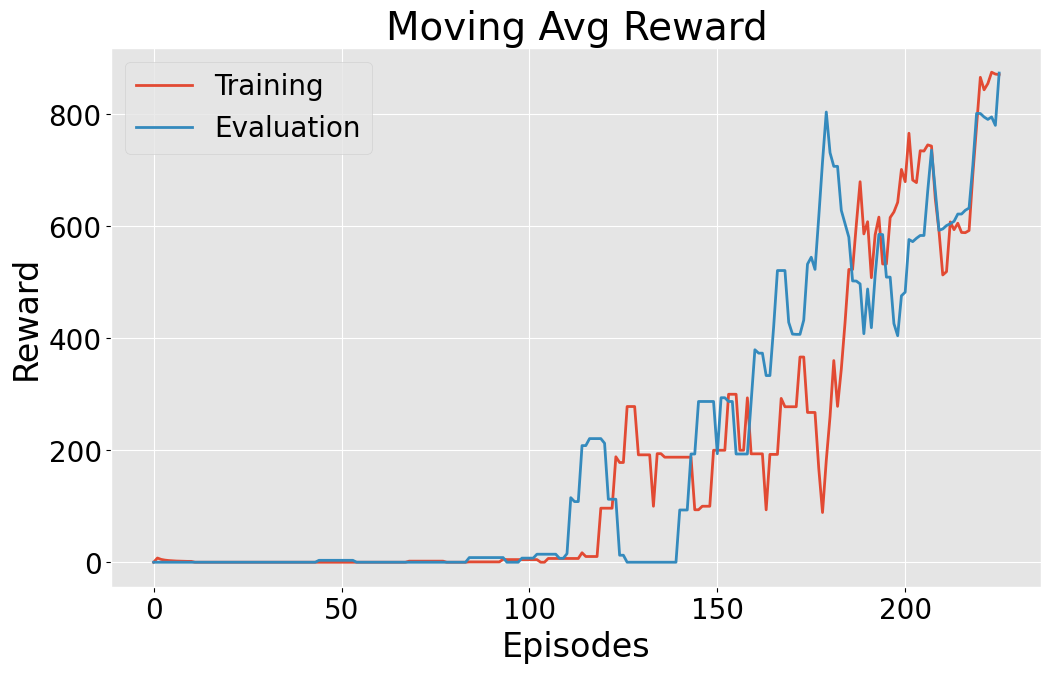

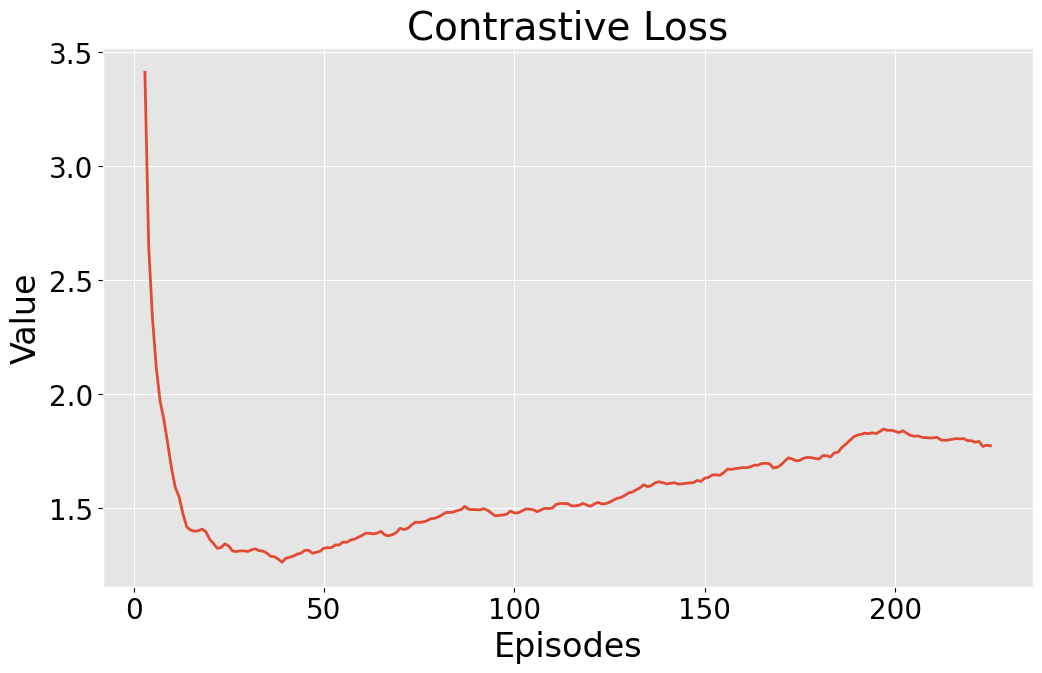

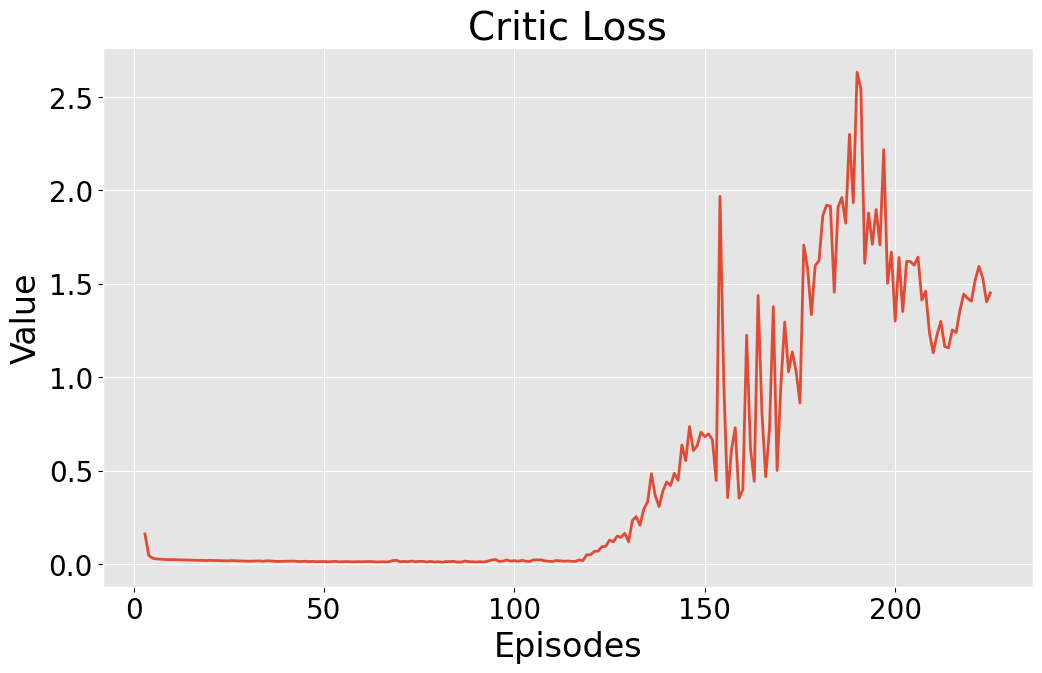

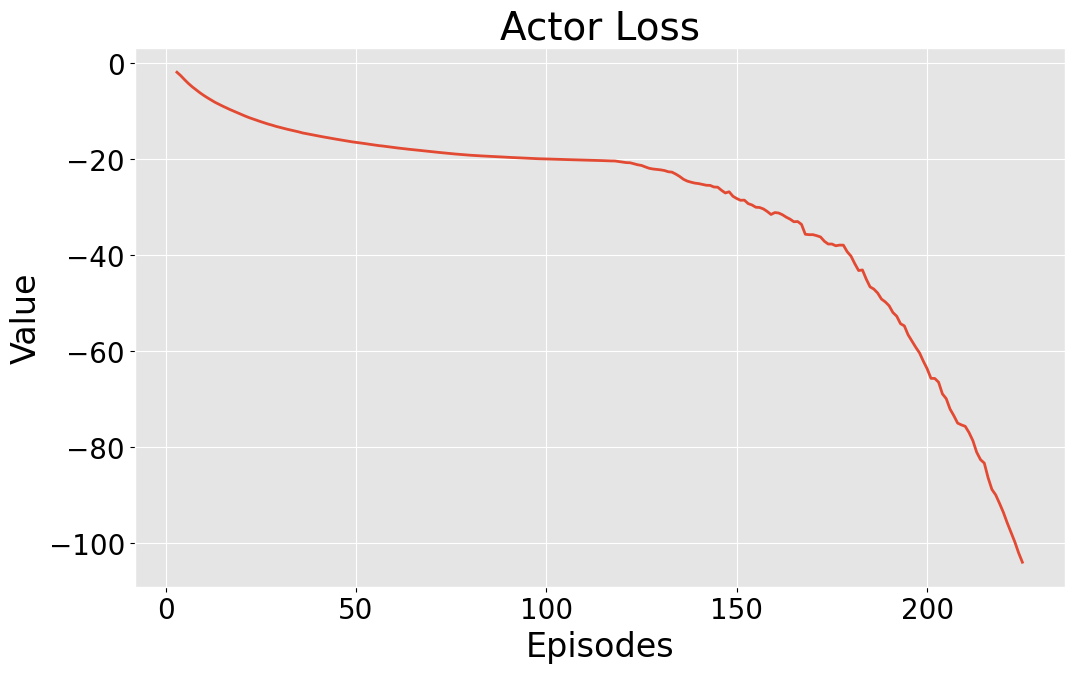

In [20]:
agent.plot_results(result)

In [21]:
agent_params = {
    "env_name": env_name,
    "ccfdm_embed_dim": embed_dim,
    "ccfdm_lr": ccfdm_lr,
    "update_key_every_steps": update_key_every_steps,
    "key_tau": key_tau,
    "obs_stack": obs_stack,
    "action_repeat": action_repeat,
    "buffer_capacity": buffer_capacity,
    "batch_size": batch_size,
    "policy_hidden_dims": policy_hidden_dims,
    "policy_optimizer_lr": policy_optimizer_lr,
    "policy_max_grad_norm": policy_max_grad_norm,
    "critic_hidden_dims": critic_hidden_dims,
    "critic_optimizer_lr": critic_optimizer_lr,
    "critic_max_grad_norm": critic_max_grad_norm,
    "n_warmup_batches": n_warmup_batches,
    "update_target_every_steps": update_target_every_steps,
    "critic_tau": critic_tau,
    "checkpoint_freq": checkpoint_freq,
    "device": str(device),
    "pixel": pixel,
    "img_size": img_size,
    "black_and_white": black_and_white,
    "seed": seed
}

file_path = os.path.join(agent.env_results_path, "sac_agent_params.txt")
with open(file_path, "w") as f:
    json.dump(agent_params, f, indent=4)

print(f"Parameters saved in: {file_path}")

Parameters saved in: ./results_raw/dm_control_pendulum-swingup-v0/sac_agent_params.txt


In [22]:
zip_name = os.path.basename(agent.results_dir)
zip_path = os.path.join(".", zip_name)

shutil.make_archive(
    base_name=zip_path.replace(".zip", ""),
    format="zip",
    root_dir=agent.results_dir
)

print("Created:", zip_path)

Created: ./results_raw


# Evaluation (from checkpoint)

In [23]:
# ====================
# EVAL CONFIGURATION
# ====================

# Reconstruct
agent = SAC(
    env_name=env_name,
    make_env_fn=make_env_fn,
    ccfdm_embed_dim=embed_dim,
    ccfdm_lr=ccfdm_lr,
    update_key_every_steps=update_key_every_steps,
    key_tau=key_tau,
    obs_stack=obs_stack,
    action_repeat=action_repeat,
    buffer_capacity=buffer_capacity,
    batch_size=batch_size,
    policy_hidden_dims=policy_hidden_dims,
    policy_optimizer_lr=policy_optimizer_lr,
    policy_max_grad_norm=policy_max_grad_norm,
    critic_hidden_dims=critic_hidden_dims,
    critic_optimizer_lr=critic_optimizer_lr,
    critic_max_grad_norm=critic_max_grad_norm,
    n_warmup_batches=n_warmup_batches,
    update_target_every_steps=update_target_every_steps,
    critic_tau=critic_tau,
    checkpoint_freq=checkpoint_freq,
    device=device,
    pixel=pixel,
    img_size=img_size,
    black_and_white=black_and_white,
    seed=seed
)

# ====================
# LOAD CHECKPOINT
# ====================

agent.load_checkpoint()

eval_env = agent.make_env_fn(**agent.make_env_kargs)
with torch.no_grad():
    agent.evaluate(eval_env, n_episodes=10, print_info=True)

eval_env.close()


Environment info:
  Observation space (Raw): 12
  After augmentation: 12
  Latent Feature space: 128
  Number of actions: 1
  Action bounds:
    Low : [-1.]
    High: [1.]
Loading model from: ./results_raw/dm_control_pendulum-swingup-v0/checkpoints/checkpoint_last_ep.pth
Model loaded successfully!
Episode 1 | Reward: 934.000
Episode 2 | Reward: 765.000
Episode 3 | Reward: 766.000
Episode 4 | Reward: 652.000
Episode 5 | Reward: 932.000
Episode 6 | Reward: 695.000
Episode 7 | Reward: 694.000
Episode 8 | Reward: 938.000
Episode 9 | Reward: 933.000
Episode 10 | Reward: 889.000
Avg. Reward: 819.800 ± 110.752


In [24]:
agent.save_video_local()

Starting episode recording for: dm_control_pendulum-swingup-v0...
Moviepy - Building video /content/results_raw/dm_control_pendulum-swingup-v0/videos/eval_dm_control_pendulum-swingup-v0-episode-0.mp4.
Moviepy - Writing video /content/results_raw/dm_control_pendulum-swingup-v0/videos/eval_dm_control_pendulum-swingup-v0-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/results_raw/dm_control_pendulum-swingup-v0/videos/eval_dm_control_pendulum-swingup-v0-episode-0.mp4
Total reward: 834.0. Recording completed.
Video saved at: /content/results_raw/dm_control_pendulum-swingup-v0/videos/eval_dm_control_pendulum-swingup-v0-episode-0.mp4


### prova3